# 06.2. Model Selection - Classification

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer,)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline # Usando o pipeline do imblearn pois esse é um dataset desbalanceado
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

### Lendo o dataset tratado e visualizando o overview atual

In [2]:
df = pd.read_csv(consts.CLUSTERED_DATASET) # Armazenando o dataset tratado em uma variável

df # Exbindo uma visão geral do dataset

,Education,Marital_Status,Children,HasChildren,Age,AgeGroup,Income,Recency,Complain,Days_Since_Enrolled,...,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Response,Cluster
0,Graduation,Single,0,0,57,46-60,58138.0,58,0,663,...,3,7,22,1529,88,1617,0,0,1,2
1,Graduation,Single,2,1,60,46-60,46344.0,38,0,113,...,2,5,4,21,6,27,0,0,0,1
2,Graduation,Partner,0,0,49,46-60,71613.0,26,0,312,...,1,4,20,734,42,776,0,0,0,0
3,Graduation,Partner,1,1,30,18-30,26646.0,26,0,139,...,2,6,6,48,5,53,0,0,0,1
4,PhD,Partner,1,1,33,31-45,58293.0,94,0,161,...,5,5,14,407,15,422,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,Graduation,Partner,1,1,47,46-60,61223.0,46,0,381,...,2,5,16,1094,247,1341,0,0,0,2
2201,PhD,Partner,3,1,68,61+,64014.0,56,0,19,...,7,7,15,436,8,444,1,1,0,2
2202,Graduation,Single,0,0,33,31-45,56981.0,91,0,155,...,1,6,18,1217,24,1241,1,1,0,0
2203,Master,Partner,1,1,58,46-60,69245.0,8,0,156,...,2,3,21,782,61,843,0,0,0,2


In [3]:
df.info() # Exibindo as informações das variáveis do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2205 non-null   object 
 1   Marital_Status        2205 non-null   object 
 2   Children              2205 non-null   int64  
 3   HasChildren           2205 non-null   int64  
 4   Age                   2205 non-null   int64  
 5   AgeGroup              2205 non-null   object 
 6   Income                2205 non-null   float64
 7   Recency               2205 non-null   int64  
 8   Complain              2205 non-null   int64  
 9   Days_Since_Enrolled   2205 non-null   int64  
 10  Years_Since_Enrolled  2205 non-null   int64  
 11  NumDealsPurchases     2205 non-null   int64  
 12  NumWebVisitsMonth     2205 non-null   int64  
 13  NumTotalPurchases     2205 non-null   int64  
 14  MntRegularProds       2205 non-null   int64  
 15  MntGoldProds         

In [4]:
fn_stats.describe(df) # Usando a função que exibe as estatísticas das colunas numéricas

,Children,HasChildren,Age,Income,Recency,Complain,Days_Since_Enrolled,Years_Since_Enrolled,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Response,Cluster
count,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00
mean,0.95,0.72,45.10,51622.09,49.01,0.01,353.72,0.48,2.32,5.34,12.57,562.76,44.06,606.82,0.30,0.21,0.15,1.09
std,0.75,0.45,11.71,20713.06,28.93,0.09,202.56,0.50,1.89,2.41,7.18,575.94,51.74,601.68,0.68,0.41,0.36,0.76
min,0.00,0.00,18.00,1730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,5.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,37.00,35196.00,24.00,0.00,180.00,0.00,1.00,3.00,6.00,56.00,9.00,69.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,44.00,51287.00,49.00,0.00,356.00,0.00,2.00,6.00,12.00,343.00,25.00,397.00,0.00,0.00,0.00,1.00
75%,1.00,1.00,55.00,68281.00,74.00,0.00,529.00,1.00,3.00,7.00,18.00,964.00,56.00,1047.00,0.00,0.00,0.00,2.00
max,3.00,1.00,74.00,113734.00,99.00,1.00,699.00,1.00,15.00,20.00,32.00,2491.00,321.00,2525.00,4.00,1.00,1.00,2.00


In [5]:
df.describe(exclude='number') # Exibindo as estatísticas das colunas categóricas

,Education,Marital_Status,AgeGroup
count,2205,2205,2205
unique,5,2,4
top,Graduation,Partner,31-45
freq,1113,1422,958


In [6]:
df.isnull().sum() # Somando todos os valores nulos de cada coluna

Education               0
Marital_Status          0
Children                0
HasChildren             0
Age                     0
AgeGroup                0
Income                  0
Recency                 0
Complain                0
Days_Since_Enrolled     0
Years_Since_Enrolled    0
NumDealsPurchases       0
NumWebVisitsMonth       0
NumTotalPurchases       0
MntRegularProds         0
MntGoldProds            0
MntTotal                0
AcceptedCmpTotal        0
HasAcceptedCmp          0
Response                0
Cluster                 0
dtype: int64

### Definindo os valores de x e y para o modelo de classificação

In [7]:
x = df.drop('Response', axis=1) # Definindo os valores de x para o modelo, separando a variável target do dataset
y = df['Response'] # Definindo os valores de y para o modelo, deixando o dataset somente com a variável target

In [8]:
x.head(3) # Visualizando os dados de x

,Education,Marital_Status,Children,HasChildren,Age,AgeGroup,Income,Recency,Complain,Days_Since_Enrolled,Years_Since_Enrolled,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,0,0,57,46-60,58138.0,58,0,663,1,3,7,22,1529,88,1617,0,0,2
1,Graduation,Single,2,1,60,46-60,46344.0,38,0,113,0,2,5,4,21,6,27,0,0,1
2,Graduation,Partner,0,0,49,46-60,71613.0,26,0,312,0,1,4,20,734,42,776,0,0,0


In [9]:
y.head(3) # Visualizando os dados de y

0    1
1    0
2    0
Name: Response, dtype: int64

### Listando as variáveis numéricas e categóricas de x

In [10]:
numerical_features = x.select_dtypes(include='number').columns # Armazenando as features numéricas em uma variável
categorical_features = x.select_dtypes(exclude='number').columns # Armazenando as features categóricas em uma variável

print('- Numerical Features:') # Printando as variávei numéricas
for feature in numerical_features:
    print(feature)

print('\n- Categorical Features:') # Printando as variávei categóricas
for feature in categorical_features:
    print(feature)

- Numerical Features:
Children
HasChildren
Age
Income
Recency
Complain
Days_Since_Enrolled
Years_Since_Enrolled
NumDealsPurchases
NumWebVisitsMonth
NumTotalPurchases
MntRegularProds
MntGoldProds
MntTotal
AcceptedCmpTotal
HasAcceptedCmp
Cluster

- Categorical Features:
Education
Marital_Status
AgeGroup


### Visualizando a distribuição das features de x em histogramas

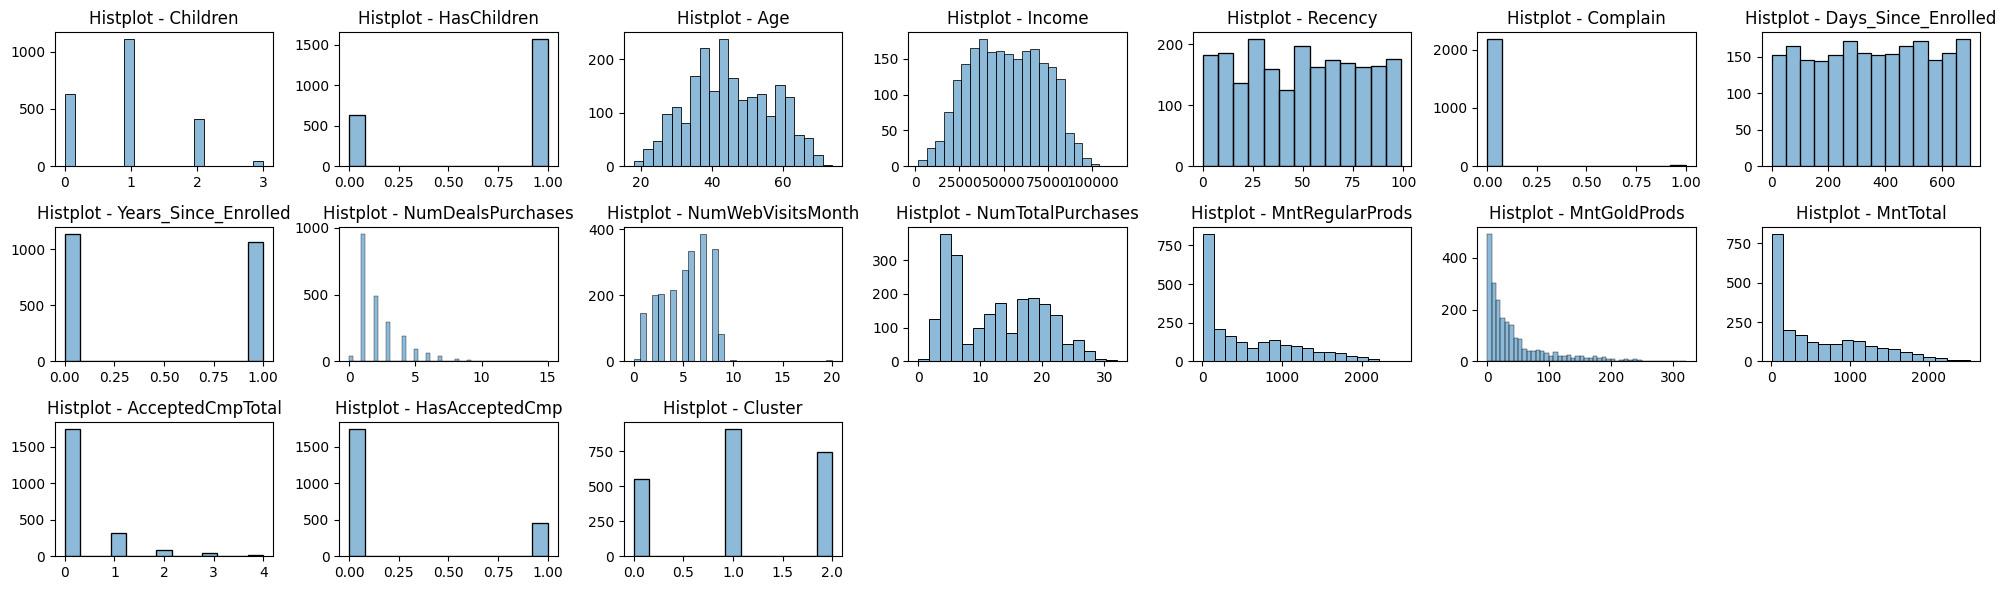

In [11]:
fn_charts.histplots(x, numerical_features, num_cols=7, height_figsize=2) # Criando os histplots para ver sua distribuição

### Definindo por qual procedimento cada feature de x vai passar

In [12]:
one_hot_cols = [ # Definindo as colunas que vão passar por One Hot Encoder
    'Education', # Coluna categórica
    'Marital_Status', # Coluna categórica
    'AgeGroup', # Coluna categórica
    'Children', # Coluna com inteiros discretos
    'HasChildren', # Coluna com inteiros discretos
    'Complain', # Coluna com inteiros discretos
    'Years_Since_Enrolled', # Coluna com inteiros discretos
    'AcceptedCmpTotal', # Coluna com inteiros discretos
    'HasAcceptedCmp', # Coluna com inteiros discretos
    'Cluster', # Coluna com inteiros discretos
]

standard_cols = [ # Definindo as colunas que vão passar por Standard Scaler
    'Income', # Coluna com distribuição semelhante à normal
    'Age', # Coluna com distribuição semelhante à normal
]

power_cols = [ # Definindo as colunas que vão passar por Power Transformation
   'NumDealsPurchases', # Coluna com assimetria dos dados
   'NumWebVisitsMonth', # Coluna com assimetria dos dados
   'NumTotalPurchases', # Coluna com assimetria dos dados
   'MntRegularProds', # Coluna com assimetria dos dados
   'MntGoldProds', # Coluna com assimetria dos dados
   'MntTotal', # Coluna com assimetria dos dados
]

min_max_cols = [ # Definindo as colunas que vão passar por Min-Max Scaler
    'Recency', # Coluna com distribuição uniforme dos dados
    'Days_Since_Enrolled', # Coluna com distribuição uniforme dos dados
]

### Definindo os modelos de classificação que serão usados

In [13]:
models = { # Definindo os modelos de classificação que serão usados
    'DummyClassifier': DummyClassifier(strategy='stratified', random_state=consts.RANDOM_STATE), # Modelo base para referência
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=consts.RANDOM_STATE),
    'LogisticRegression': LogisticRegression(random_state=consts.RANDOM_STATE),
    'KNNClassifier': KNeighborsClassifier(n_neighbors=5),
}

### Criando a função com o pipeline

In [14]:
def pipeline( # Função para fazer todo o procedimento de pipeline e validação cruzada, e retornar os scores
    x, # Passando o x como parâmetro da função
    y, # Passando o y como parâmetro da função
    model, # Passando o modelo como parâmetro da função
): 

    preprocessing = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
        [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
            ('one_hot', OneHotEncoder(), one_hot_cols),
            ('standard', StandardScaler(), standard_cols),
            ('min_max', MinMaxScaler(), min_max_cols),
            ('power', PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline( # Criando o pipeline para o modelo de classificação (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
        [ # Passando as etapas do pipeline
            ('pre_processing', preprocessing), # Fazendo o pré processamento conforme as definições anteriores
            ('feature_selection', SelectKBest(score_func=f_classif, k=10)), # Selecionando as melhores features para o modelo 
                # (Obs: nesse caso, não é indicado o uso de PCA pois ocasionaria a perda de features para comunicar os resultados posteriormente)
            ('resampling', RandomUnderSampler(random_state=consts.RANDOM_STATE)), # Tratando o dataset desbalanceado com Random Under Sampler (RUS)
            ('models', model), # Aplicando o modelo passado para a função
        ]
    )

    scores = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
            # visando ter diversos valores para as métricas, e assim trabalhar com os valores médios ou mais frequentes
        pipeline, # Passando o pipeline definido acima
        x, # Passando o dataset x
        y, # Passando o dataset y
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset 
            # desbalanceado, com um número inicial de 5 folds e aplicando o shuffle pois não se trata de um caso de séries temporais
        scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], # Definindo as métricas de avaliação dos modelos
        n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
    )

    return scores # Retornando os scores

### Aplicando a função com o pipeline e armazenando os resultados de cada modelo

In [15]:
results = { # Aplicando a função com o Pipeline, passando os datasets x, y e os modelos, e armazenando os resultados em uma variável
    'DummyClassifier': pipeline(x, y, models['DummyClassifier']),
    'DecisionTreeClassifier': pipeline(x, y, models['DecisionTreeClassifier']),
    'LogisticRegression': pipeline(x, y, models['LogisticRegression']),
    'KNNClassifier': pipeline(x, y, models['KNNClassifier']),
}

### Criando um dataset com os resultados dos modelos

In [16]:
for key, value in results.items(): # Criando uma estrutura de repetição para percorrer os resultados dos modelos
    results[key]['time'] = results[key]['fit_time'] + results[key]['score_time'] # Criando a coluna de tempo somando fit_time e score_time

df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'}) # Criando um df transposto com os resultados dos modelos

df_results_explode = df_results.explode(df_results.columns[1:].to_list()).reset_index(drop=True) # Criando um df separando os maps por linhas

df_results_explode # Exibindo o dataset com os resultados dos modelos

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.087234,0.055147,0.512472,0.154206,0.492537,0.50429,0.15305,0.142382
1,DummyClassifier,0.08273,0.055648,0.503401,0.14486,0.462687,0.486691,0.148657,0.138378
2,DummyClassifier,0.105458,0.057678,0.503401,0.14486,0.462687,0.486691,0.148657,0.163136
3,DummyClassifier,0.07921,0.036277,0.487528,0.126168,0.409091,0.455212,0.14005,0.115487
4,DummyClassifier,0.095922,0.03612,0.510204,0.149533,0.484848,0.499758,0.149598,0.132041
5,DecisionTreeClassifier,0.041048,0.021032,0.693878,0.276316,0.626866,0.667551,0.232212,0.062079
6,DecisionTreeClassifier,0.040123,0.02696,0.643991,0.22561,0.552239,0.613197,0.194891,0.067083
7,DecisionTreeClassifier,0.050048,0.020029,0.680272,0.279762,0.701493,0.679543,0.242778,0.070076
8,DecisionTreeClassifier,0.048563,0.020042,0.639456,0.221557,0.560606,0.603758,0.187408,0.068606
9,DecisionTreeClassifier,0.050566,0.030559,0.70068,0.301205,0.757576,0.724121,0.264467,0.081125


### Comparando os resultados dos modelos através de boxplots

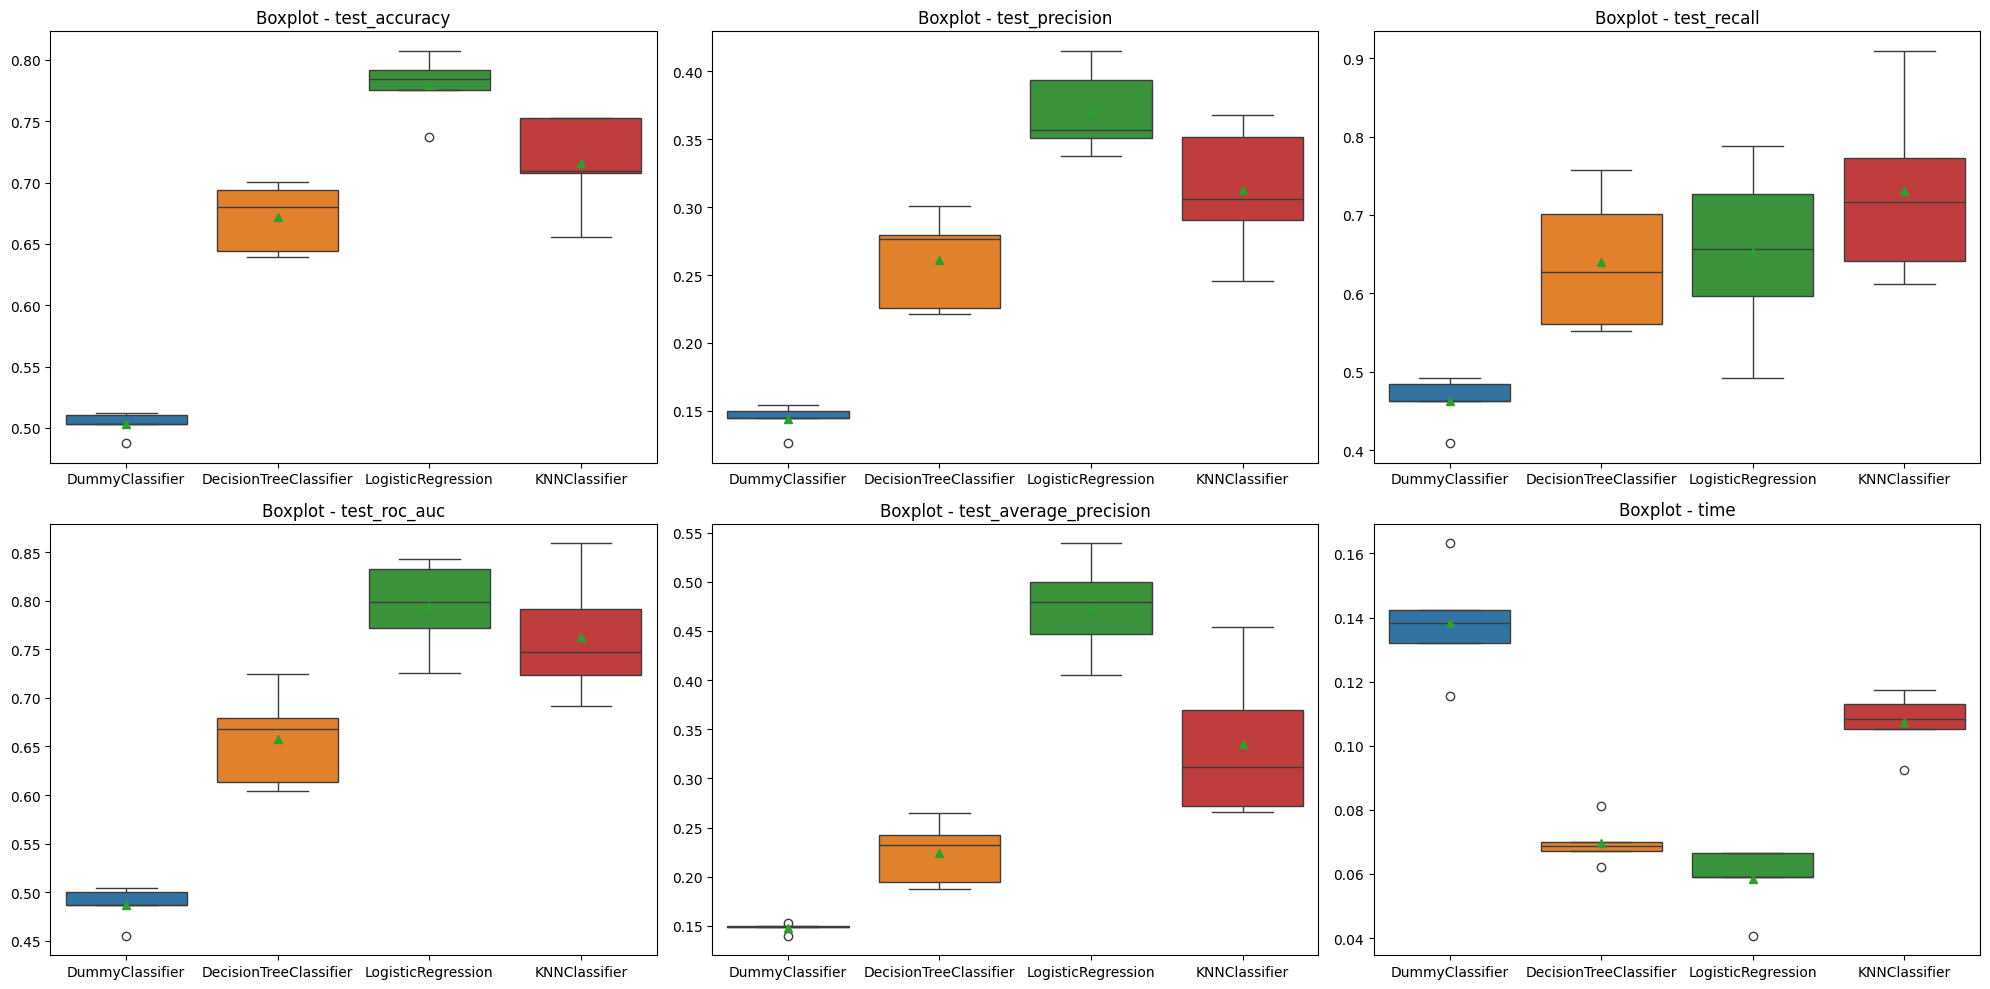

In [17]:
fn_charts.boxplots(df_results_explode, df_results.columns[3:].to_list(), 'model') # Criando os boxplots para avaliação dos modelos

### Avaliando os resultados de cada modelo

| Posição    | Accuracy              | Precision             | Recall                | AUC-ROC               | Average Precision     | Time                  |
|------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| Referência | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto menor melhor    |
| 1          | **LogisticRegression**     | **LogisticRegression**     | KNNClassifier          | **LogisticRegression**     | **LogisticRegression**     | **LogisticRegression**     |
| 2          | KNNClassifier          | KNNClassifier          | **LogisticRegression**     | KNNClassifier          | KNNClassifier          | DummyClassifier        |
| 3          | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier |
| 4          | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | KNNClassifier          |

### Definindo o modelo que será utilizado no projeto de classificação

Após análise dos resultados de cada um dos modelos, é possível concluir que o modelo com os melhores resultados foi o de Logistic Regression, pois liderou os resultados nas métricas de Accuracy, Precision, AUC-ROC, Average Precision e Time, e ficou na segunda posição na métrica de Recall. Além disso, no caso de datasets desbalanceados como é o caso desse estudo, as principais métricas avaliadas são o AUC-ROC e o Average Precision, onde o modelo de Logistic Regression também obteve as melhores performances. E em relação ao processamento, esse modelo também teve a melhor performance com o menor tempo de processamento. 

Portando, diante de todo esse contexto, **o melhor modelo para ser usado no projeto é o Logistic Regression**.